In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [20]:
with open("../VC-T0_3B-MLP-10-rices-1-shot-hotpotqa.pkl", "rb") as f:
    answer_list_hotpotqa = pickle.load(f)

with open("../VC-T0_3B-MLP-10-rices-0-shot-hotpotqa.pkl", "rb") as f:
    answer_list_hotpotqa_zero_shot = pickle.load(f)

with open("../VC-T0_3B-MLP-10-rices-1-shot-frozen.pkl", "rb") as f:
    answer_list_frozen = pickle.load(f)

with open("../VC-T0_3B-MLP-10-rices-0-shot-frozen.pkl", "rb") as f:
    answer_list_frozen_zero_shot = pickle.load(f)

save_path = Path("/home/rsa39/rds/rds-mlmi-2020-21-xyBFuSj0hm0/MLMI.2021-22/rsa39/project/RAVQA/data/figures_for_report")

## Answer lengths

In [3]:
def convert_answer_stats_to_df(answer_list):
    answer_lengths = []
    num_words = []
    for answer_dict in answer_list:
        answer_lengths.append(len(answer_dict['answer']))
        num_words.append(len(answer_dict['answer'].split(" ")))

    df = pd.DataFrame({"answer_lengths": answer_lengths, "# Words": num_words})
    return df

df_hotpotqa = convert_answer_stats_to_df(answer_list_hotpotqa_zero_shot)
df_frozen = convert_answer_stats_to_df(answer_list_frozen_zero_shot)
df_hotpotqa["Template"] = "hotpotqa"
df_frozen["Template"] = "frozen"
df = pd.concat([df_frozen[df_frozen["# Words"] < 10], df_hotpotqa[df_hotpotqa["# Words"] < 10]], ignore_index=True)
df.head()

,answer_lengths,# Words,Template
0,32,6,frozen
1,23,3,frozen
2,13,3,frozen
3,17,5,frozen
4,17,5,frozen


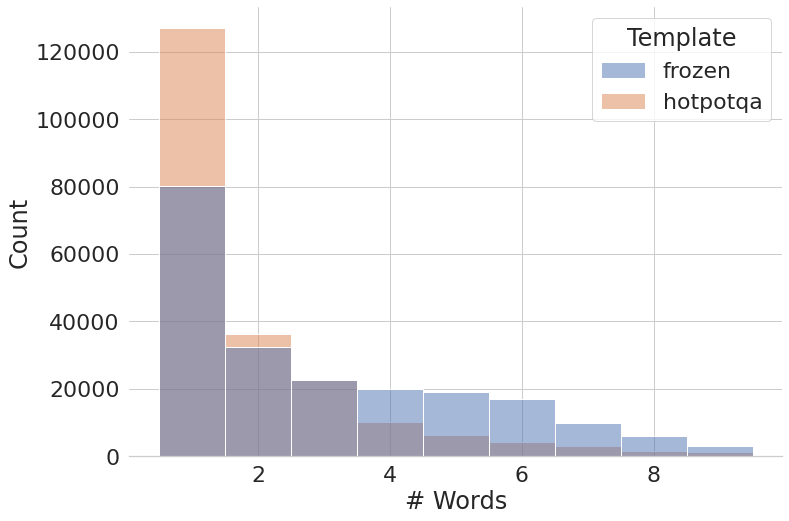

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale = 2)
sns.set_style("whitegrid")
sns.histplot(data=df, x="# Words", hue="Template", discrete=True) #, stat="density")   # , palette=col)
sns.despine(left = True)
plt.savefig(save_path / "0-shot-num-words.pdf", bbox_inches="tight")

## Answers from in-context examples

In [21]:
from visualise_in_context_examples import load_in_context_examples_for_question_id, select_best_k
from pathlib import Path
import sys
sys.path.append("../utils")
from vqa_tools import VQA
from vqaEval import VQAEval

data_dir = Path("../../data")
vqa2_data_dir = data_dir / "vqa2"
in_context_examples_dir = vqa2_data_dir / "pre-extracted_features" / "in_context_examples"
cached_val_vqa_data_path = vqa2_data_dir / "cache/val_data_preprocessed.pkl"

in_context_examples_fname = "rices.pkl"

In [22]:
in_context_examples_file_path = in_context_examples_dir / in_context_examples_fname
print(f"Reading in-context examples from {in_context_examples_file_path}")
with open(in_context_examples_file_path, "rb") as f:
    in_context_examples = pickle.load(f)

Reading in-context examples from ../../data/vqa2/pre-extracted_features/in_context_examples/rices.pkl


In [23]:
matched_answers = 0
for answer_dict in answer_list_hotpotqa:
    question_id = answer_dict['question_id']
    answer = answer_dict['answer']
    in_context_examples_for_item = in_context_examples[str(question_id)]
    in_context_examples_for_item = in_context_examples_for_item[-1:]
    for example in in_context_examples_for_item:
        # print(example)
        if example["gold_answer"] == answer:
            matched_answers += 1
            break
    # break
print(matched_answers/len(answer_list_hotpotqa))

0.16044020638756448


In [12]:
answer_list_new = []
for answer_dict in answer_list_hotpotqa:
    question_id = answer_dict['question_id']
    answer = answer_dict['answer']
    in_context_examples_for_item = in_context_examples[str(question_id)]
    in_context_examples_for_item = in_context_examples_for_item[-1:]
    for example in in_context_examples_for_item:
        if example["gold_answer"] != answer:
            answer_dict['answer'] = "Ths cncat bes thio rdsv"
            continue
        # elif example["gold_answer"] != answer:
        #     answer_dict['answer'] = example["gold_answer"]
        #     continue
    answer_list_new.append(answer_dict)

In [88]:
answer_list_new[1]

{'question_id': 262148001,
 'answer': 'skateboarding',
 'image_id': 262148,
 'question_type': 'what are the',
 'answer_type': 'other'}

## In-context example as answer

In [24]:
answer_list_new = []
for answer_dict in answer_list_hotpotqa:
    question_id = answer_dict['question_id']
    answer = answer_dict['answer']
    in_context_examples_for_item = in_context_examples[str(question_id)]
    in_context_examples_for_item = in_context_examples_for_item[-1:]
    for example in in_context_examples_for_item:
        answer_dict['answer'] = example["gold_answer"]
    answer_list_new.append(answer_dict)

In [49]:
answer_list_new[1], answer_list[1]

({'question_id': 262148001,
  'answer': 'yes',
  'image_id': 262148,
  'question_type': 'what are the',
  'answer_type': 'other'},
 {'question_id': 262148001,
  'answer': 'no',
  'image_id': 262148,
  'question_type': 'what are the',
  'answer_type': 'other'})

In [25]:
vqa_helper = VQA(vqa2_data_dir / "v2_mscoco_val2014_annotations.json", vqa2_data_dir / "v2_OpenEnded_mscoco_val2014_questions.json")
vqaRes = vqa_helper.loadResFromDict(answer_list_new)
vqaEval = VQAEval(
    vqa_helper, vqaRes, n=2
)  # n is precision of accuracy (number of places after decimal), default is 2
vqaEval.evaluate()
print(
    "Overall Accuracy is: %.02f\n" % (vqaEval.accuracy["overall"])
)

loading VQA annotations and questions into memory...
time elpased:  0:00:04.124031
creating index...
index created!
Loading and preparing results...     
DONE (t=1.83s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Overall Accuracy is: 36.97



In [17]:
(vqaEval.accuracy["overall"] * len(answer_list_hotpotqa))/(len(answer_list_hotpotqa)-matched_answers)
# (vqaEval.accuracy["overall"] * len(answer_list_hotpotqa))/matched_answers

29.392484512299436

In [18]:
print(
    "Overall Accuracy is: %.02f\n" % (vqaEval.accuracy["overall"])
)

Overall Accuracy is: 15.87

